# Toxikind: Data Exploration + Baseline Re

In [4]:
# OS I/O
import os
import pickle

# Data handling
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate, GridSearchCV #, cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay #, classification_report# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Pure Preprocessing:
1. Import Raw Data
2. Scaling Pipeline (Features)
3. Merge by Index (all the data) (export)
-> .py-file and scaled full dataset in data folder

Modeling: (assumption: NAs are removed)
1. Select Target(s) by user/environement list
2. Put in function which selects the target(s) of interest (by removing the other) and drops all NAs

# Features (Train)

**Load data:**

In [5]:
path_features_train = "../raw_data/tox21_dense_train.csv.gz"
X_raw = pd.read_csv(path_features_train).set_index("Unnamed: 0")

**Shape:**

In [6]:
X_raw.shape

(12060, 801)

**Table info:**

In [7]:
X_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12060 entries, NCGC00178831-03 to NCGC00261465-01
Columns: 801 entries, AW to rygr
dtypes: float64(761), int64(40)
memory usage: 73.8+ MB


**Table view:**

**Pipeline: Scale all features and retain colnames + index:**

In [8]:
# Column Transformer with MinMax-Scaler
column_transformer = ColumnTransformer([
    ("scaler", MinMaxScaler(), X_raw.columns)
    ])

# Pipeline
pipeline = Pipeline([
    ("transform", column_transformer)
    ])

# Transform data while preserving column names
X = pd.DataFrame(pipeline.fit_transform(X_raw), columns=X_raw.columns, index=X_raw.index)

# Targets (Train)

**Load data:**

In [9]:
path_targets_train = "../raw_data/tox21_labels_train.csv.gz"
y = pd.read_csv(path_targets_train).set_index("Unnamed: 0")

**Shape:**

In [10]:
y.shape

(12060, 12)

**Table info:**

In [11]:
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12060 entries, NCGC00178831-03 to NCGC00261465-01
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   NR.AhR         8441 non-null   float64
 1   NR.AR          9654 non-null   float64
 2   NR.AR.LBD      8852 non-null   float64
 3   NR.Aromatase   7440 non-null   float64
 4   NR.ER          7962 non-null   float64
 5   NR.ER.LBD      9040 non-null   float64
 6   NR.PPAR.gamma  8451 non-null   float64
 7   SR.ARE         7401 non-null   float64
 8   SR.ATAD5       9363 non-null   float64
 9   SR.HSE         8417 non-null   float64
 10  SR.MMP         7558 non-null   float64
 11  SR.p53         8903 non-null   float64
dtypes: float64(12)
memory usage: 1.2+ MB


**Table view:**

**Number of missing values per target:**

In [12]:
y.isnull().sum().sort_values(ascending=False)

SR.ARE           4659
NR.Aromatase     4620
SR.MMP           4502
NR.ER            4098
SR.HSE           3643
NR.AhR           3619
NR.PPAR.gamma    3609
NR.AR.LBD        3208
SR.p53           3157
NR.ER.LBD        3020
SR.ATAD5         2697
NR.AR            2406
dtype: int64

**Labels and NAs per target:**

In [13]:
# Calculate number of toxic, non toxic and NA
experiments = y.columns
exp_stats = []

for i in experiments:
    n_toxic = sum(y[i] ==1)
    n_non_toxic = sum(y[i] ==0)
    n_nan = sum(y[i].isna())
    percent_toxic = n_toxic / (n_toxic + n_non_toxic) * 100
    percent_non_toxic = 100 - percent_toxic
    exp_stats.append([i, n_toxic, n_non_toxic, n_nan, percent_toxic, percent_non_toxic])

In [14]:
# As DataFrame
stats_df = pd.DataFrame(exp_stats, columns=["experiment", "toxic", "non_toxic", "NA", "percent_toxic", "percent_non_toxic"])
stats_df

,experiment,toxic,non_toxic,NA,percent_toxic,percent_non_toxic
0,NR.AhR,981,7460,3619,11.621846,88.378154
1,NR.AR,383,9271,2406,3.967267,96.032733
2,NR.AR.LBD,307,8545,3208,3.468143,96.531857
3,NR.Aromatase,378,7062,4620,5.080645,94.919355
4,NR.ER,964,6998,4098,12.107511,87.892489
5,NR.ER.LBD,456,8584,3020,5.044248,94.955752
6,NR.PPAR.gamma,237,8214,3609,2.804402,97.195598
7,SR.ARE,1146,6255,4659,15.484394,84.515606
8,SR.ATAD5,363,9000,2697,3.876963,96.123037
9,SR.HSE,438,7979,3643,5.203754,94.796246


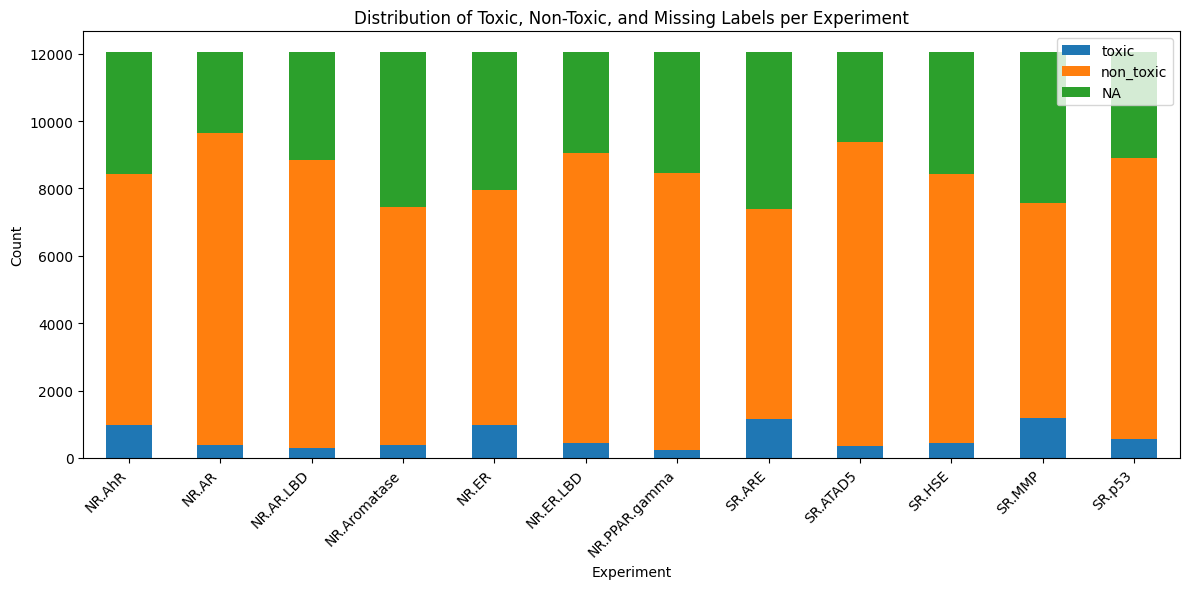

In [15]:
# Plot toxic, non toxic, NA
stats_df[["experiment", "toxic", "non_toxic", "NA"]]\
    .set_index("experiment").plot(kind="bar", stacked=True, figsize=(12, 6))
plt.title("Distribution of Toxic, Non-Toxic, and Missing Labels per Experiment")
plt.ylabel("Count")
plt.xlabel("Experiment")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

**Labels per target:**

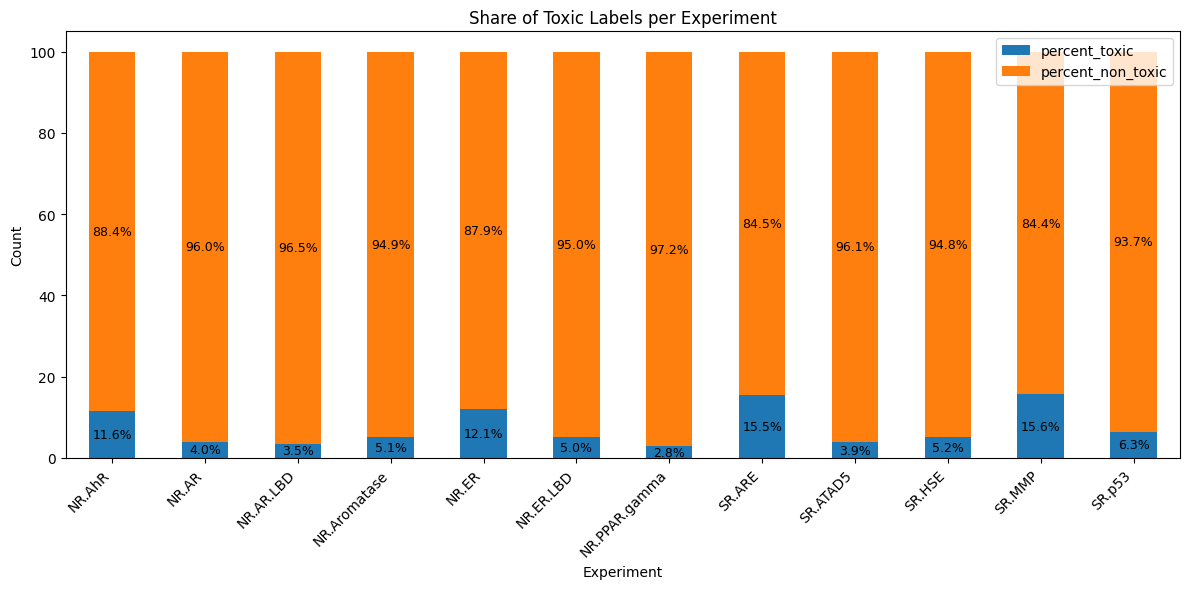

In [16]:
# Generate the stacked bar chart
ax = stats_df[["experiment", "percent_toxic", "percent_non_toxic"]].set_index("experiment") \
    .plot(kind="bar", stacked=True, figsize=(12, 6))

# Extract experiment names (to match labels correctly)
experiment_names = stats_df["experiment"].values

# Add labels (loop through bars)
for bars, col in zip(ax.containers, ["percent_toxic", "percent_non_toxic"]):
    for bar, experiment in zip(bars, experiment_names):
        height = bar.get_height()  # Get the height of each segment
        if height > 0:  # Avoid labeling zero-height bars
            ax.text(bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f"{stats_df.loc[stats_df['experiment'] == experiment, col].values[0]:.1f}%",
                    ha="center", va="center", color="black", fontsize=9)

plt.title("Share of Toxic Labels per Experiment")
plt.ylabel("Count")
plt.xlabel("Experiment")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()
# Thank you, Microsoft Copilot!

**Correlation between targets:**

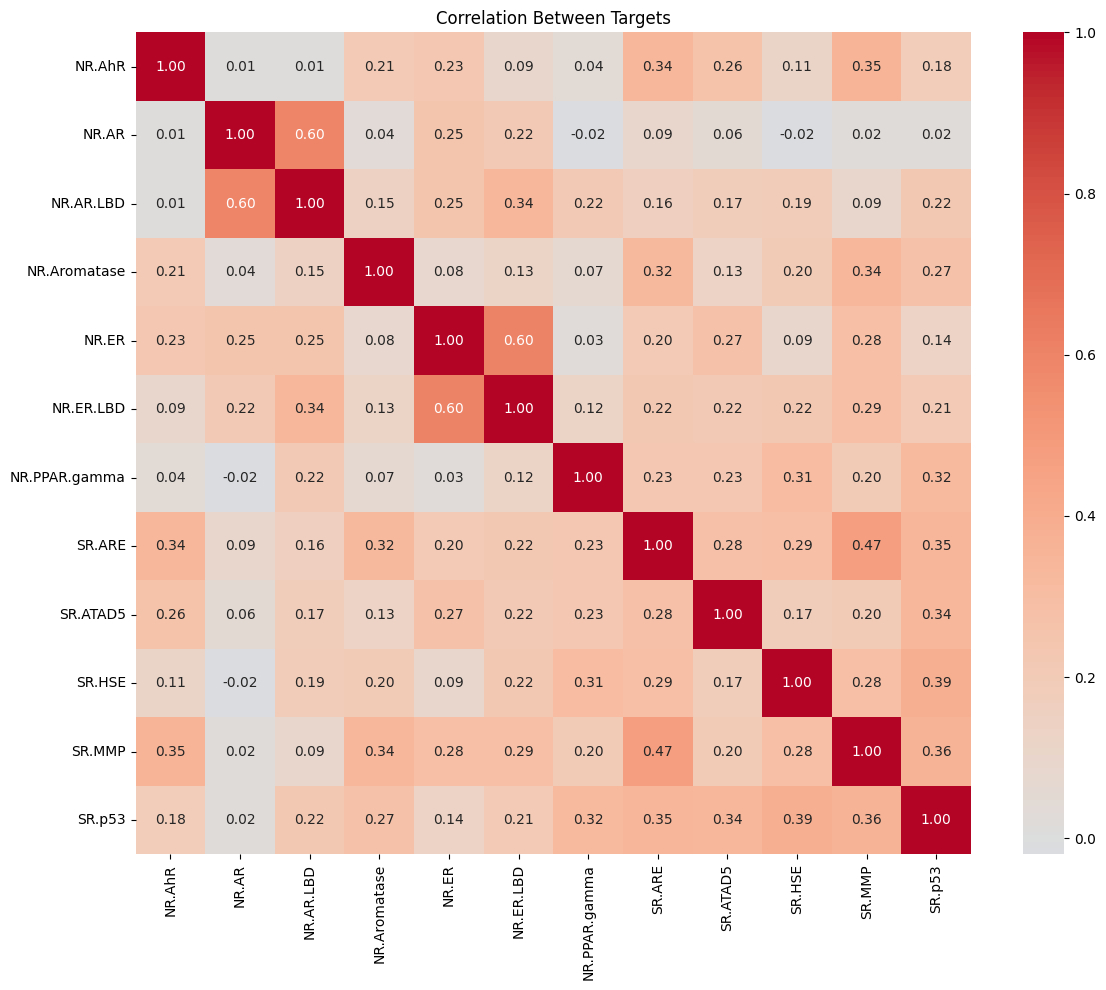

In [17]:
# Calculate Correlation Matrix
target_corr = y.corr()

# Create Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(target_corr,
           annot=True,  # Show numbers
           cmap="coolwarm",  # Blue-red color scheme
           center=0,  # Center the colormap at 0
           fmt=".2f" # Round to 2 decimal places
           )

plt.title("Correlation Between Targets")
plt.tight_layout()
plt.show()

# Baseline Model: Random Forest 

### Target: "SR.MMP"

**Create single target without NAs:**

In [18]:
y_mmp = y[["SR.MMP"]].dropna()

In [19]:
y_mmp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7558 entries, NCGC00165865-01 to NCGC00261465-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SR.MMP  7558 non-null   float64
dtypes: float64(1)
memory usage: 118.1+ KB


**Inner merge with features:**

In [20]:
mmp_train = y_mmp.merge(X, how="inner", on="Unnamed: 0")

In [21]:
mmp_train.head()

,SR.MMP,AW,AWeight,Arto,BertzCT,Chi0,Chi1,Chi10,Chi2,Chi3,...,W3D,W3DH,WNSA1,WNSA2,WNSA3,WPSA1,WPSA2,WPSA3,grav,rygr
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
NCGC00165865-01,1.0,6.341000e-08,0.017366,0.812523,0.789928,0.273763,0.270577,0.119708,0.282093,0.256368,...,0.041851,0.032067,0.195228,0.987276,0.964649,0.085498,0.016266,0.032846,0.000227,0.323018
NCGC00095025-01,1.0,4.232804e-01,0.009179,0.776528,0.677698,0.213232,0.215202,0.053085,0.195447,0.160676,...,0.019685,0.032279,0.042972,0.996306,0.977962,0.097667,0.024509,0.038591,0.000160,0.233044
NCGC00255209-01,1.0,8.695657e-02,0.012498,0.717285,0.649496,0.169998,0.168857,0.022973,0.148787,0.113646,...,0.014453,0.029822,0.053196,0.996467,0.968684,0.099991,0.019386,0.035609,0.000114,0.264252
NCGC00260005-01,1.0,3.760000e-08,0.005746,0.809899,0.755683,0.190918,0.187776,0.047752,0.192760,0.187370,...,0.014743,0.018509,0.058717,0.996961,0.985609,0.081238,0.012272,0.031258,0.000129,0.220536
NCGC00258363-01,1.0,5.882360e-02,0.022841,0.705662,0.636547,0.256603,0.257801,0.048654,0.195549,0.162270,...,0.046014,0.117323,0.077582,0.991233,0.939187,0.269463,0.088882,0.090879,0.000196,0.371946


### Initialize Decision Tree

**Split again:**

In [22]:
X_mmp_train = mmp_train.drop(columns=["SR.MMP"])
print(X_mmp_train.shape)
y_mmp_train = mmp_train["SR.MMP"]
print(y_mmp_train.shape)


(7558, 801)
(7558,)


**Model fit and evaluation:**

In [23]:
# Model Instantiation and Fit
random_forest = RandomForestClassifier()
random_forest.fit(X_mmp_train, y_mmp_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [24]:
# Cross-validation
random_forest_mmp_cv = cross_validate(random_forest
                                    , X=X_mmp_train, y=y_mmp_train, cv=5,
                                scoring=["accuracy",
                                         "recall",
                                         "precision",
                                         "f1"
                                        ]
                               )

In [25]:
random_forest_mmp_scoring_metrics = pd.DataFrame((list(random_forest_mmp_cv.values()))[2:]).mean(axis=1)
keys = ["accuracy", "recall", "precision", "f1"]
logit_scoring_metrics = dict(zip(keys, list(random_forest_mmp_cv)))
logit_scoring_metrics

{'accuracy': 'fit_time',
 'recall': 'score_time',
 'precision': 'test_accuracy',
 'f1': 'test_recall'}

### Save Model to Pickle File 

In [28]:
# save the model to disk
filename = 'random_forest_mmp_model.pkl'
pickle.dump(random_forest, open(filename, 'wb'))

## Target: SR.ARE